# Подготовка всего необходимого

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, FuncFormatter)
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import (
    UnivariateSpline,
    CubicSpline,
    make_interp_spline,
    InterpolatedUnivariateSpline,
)
import warnings


def mnk(approx_func, x, y, *args):
    """
    Возвращает относительную погрешность аппроксимации к функции approx_func.

    *args - дополнительные аргументы, которые подставляются в approx_func.
    """
    ret = 0
    for i in range(len(x)):
        # print(y[i], np.polyval(polynom, x[i]))
        if y[i] != 0:
            ret += abs((y[i] - approx_func(x[i], *args)) / y[i])
        else:
            warnings.warn("МНК не работает при нулевой ординате!")
    return ret / len(x)


def linear_approx_func(x, a, b):
    """Функция, к которой по-умолчанию считается аппроксимация."""
    return a * x + b


def approx_label(vals, error, phrase, str_to_replace="★", decimal_places=[2, 2]):
    """
    Позволяет быстро подставлять в строку значения с ошибкой и округлением вместо фигурных скобок.
    """
    formatted_vals = vectorized_to_latex(vals, decimal_places=decimal_places[0])
    formatted_error = vectorized_to_latex(error, decimal_places=decimal_places[1])
    
    ret = []
    for i in range(len(formatted_vals)):
        ret.append("(" + str(formatted_vals[i]) + r"\pm" + str(formatted_error[i]) + ")")
        
    result = phrase
    for i in ret:
        result = result.replace(str_to_replace, i, 1)
    
    return result

def to_latex_format(x, decimal_places=2):
    # Приводим число к научной нотации
    scientific_notation = f"{x:.{decimal_places}e}"
    # Разделяем число на мантиссу и порядок
    mantissa, exponent = scientific_notation.split('e')
    # Преобразуем порядок в целое число и удаляем ведущий знак
    exponent = int(exponent)
    # Форматируем в виде LaTeX
    if exponent != 0:
        return r"{} \cdot 10^{{{}}}".format(mantissa, exponent)
    else:
        return r"{}".format(mantissa)

# Применение векторизованной функции к массиву
vectorized_to_latex = np.vectorize(to_latex_format)

In [43]:
# соотношение сторон в графике
X = 2
Y = 1
# длина графика по горизонтали
L = 18

inch = 2.54

# Производим измерения

In [44]:
import subprocess
import random

sorting = "heap"/"merge"

In [45]:
sorting = "heap"

start = 10_000
end = 1_000_000
step = 10_000

In [46]:
df = pd.DataFrame(columns=["N", "Time"])

for i in range(start, end, step):
    process1 = subprocess.run(
        [
            "sortings_implementation.exe",
            str(i),
            str(random.randint(0, 1_000_000_000)),
            str(sorting),
        ],  # Имя программы и параметры
        text=True,  # Для работы с текстом, а не байтами
        capture_output=True,  # Для захвата stdout и stderr
        encoding="utf-8",  # Задать правильную кодировку
    )
    df.loc[len(df)] = [i, float(process1.stdout)]

"""
# Вывод результата
print("STDOUT:", process1.stdout)  # Стандартный вывод
print("STDERR:", process1.stderr)  # Ошибки, если есть
"""

'\n# Вывод результата\nprint("STDOUT:", process1.stdout)  # Стандартный вывод\nprint("STDERR:", process1.stderr)  # Ошибки, если есть\n'

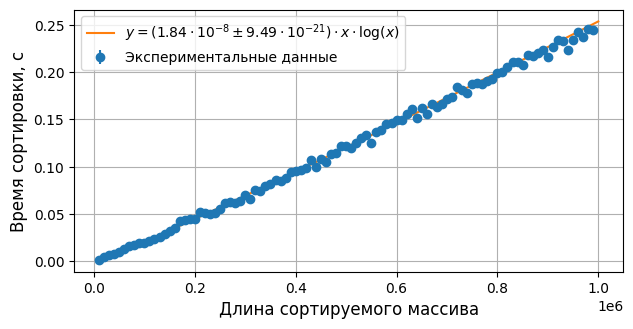

In [47]:
x, y = df["N"], df["Time"]
y_err = 0.002 * np.abs(y)

plt.figure(figsize=(L / inch, (L * Y / X) / inch))


plt.errorbar(
    x,
    y,
    fmt="o",
    label="Экспериментальные данные",
    # xerr=x_err,
    yerr=y_err,
)

'''
# наклонная
slc = slice(None, None)
vals, error = curve_fit(linear_approx_func, x[slc], y[slc], sigma=y_err[slc], p0=None)
error = np.diag(error)
plt.plot(
    x,
    linear_approx_func(x, *vals),
    label=approx_label(vals, error, r"$y = э x + э$", str_to_replace="э"),
)
'''


# n * log n
def frac(x, a):
    return a * x * np.log(x)


vals, error = curve_fit(frac, x, y, sigma=y_err, p0=None)
error = np.diag(error)
x_approx = np.linspace(start, end, step)
plt.plot(
    x_approx,
    frac(x_approx, *vals),
    label=approx_label(vals, error, r"$y = ★ \cdot x \cdot \log(x)$"),
)

plt.grid()
plt.xlabel(r"Длина сортируемого массива", fontsize=12)
plt.ylabel(r"Время сортировки, с", fontsize=12)
plt.legend()
plt.subplots_adjust(bottom=0.14)

plt.savefig(f"{sorting}.pdf")